## Problem Statement :
### A cloth manufacturing company is interested to know about the segment or attributes causes high sale. 
#### Approach - A Random Forest can be built with target variable Sale (we will first convert it in categorical variable) & all other variable will be independent in the analysis.

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from collections import Counter
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

import warnings
warnings.filterwarnings('ignore')

## 2. Importing Dataset

In [2]:
company_data = pd.read_csv('D:\Assignment ExcelR\Random Forests\Company_Data.csv')
company_data

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


#### About the data: 
**Let’s consider a Company dataset with around 10 variables and 400 records. 
The attributes are as follows:**

* **Sales** -- Unit sales (in thousands) at each location

* **Competitor Price** -- Price charged by competitor at each location

* **Income** -- Community income level (in thousands of dollars)

* **Advertising** -- Local advertising budget for company at each location (in thousands of dollars)

* **Population** -- Population size in region (in thousands)

* **Price** -- Price company charges for car seats at each site

* **Shelf Location at stores** -- A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

* **Age** -- Average age of the local population

* **Education** -- Education level at each location

* **Urban** -- A factor with levels No and Yes to indicate whether the store is in an urban or rural location

* **US** -- A factor with levels No and Yes to indicate whether the store is in the US or not

## 3. Data Understanding

In [3]:
company_data.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

### 3.1 Descriptive Analysis

In [4]:
company_data.shape

(400, 11)

In [5]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [6]:
company_data[company_data.duplicated()].shape

(0, 11)

In [7]:
company_data.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


### 3.2 Feature Engineering

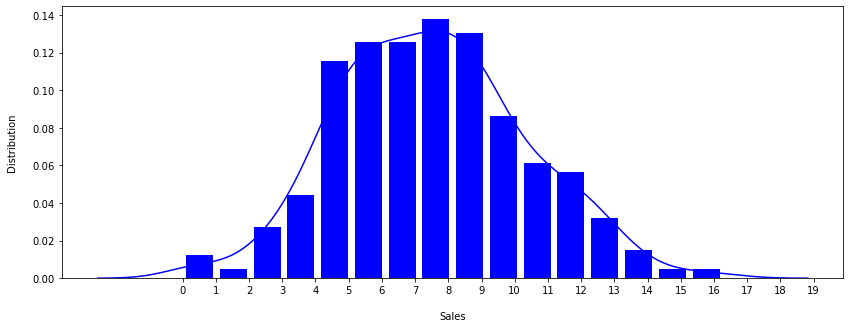

In [8]:
def distplot(param):
    plt.figure(figsize=(14,5))
    sns.distplot(company_data[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1))
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Sales")

As the Sales distribution is not skewed and it is normal distribution we can take mean or median as a threshold to make two or three categories 'Low', 'Medium' and 'High' Sales

For two categories lets assume: Sales < 7.5 as “Bad=0” and Sales > 7.5 as “Good=1”

For three categories lets divide the Sales values with Quartiles , less than first quartile as 'Low' , between Second Quartile as 'Medium and above Third Quartile as 'High'

In [9]:
company_data.Sales.describe()

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

In [10]:
company_data1 = company_data.copy()
company_data1['SalesCat'] = pd.cut(x = company_data1['Sales'], bins = [0,5.39,9.32,17], labels=['Low','Medium','High'], right = False)
company_data1.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,SalesCat
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,High
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,High
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,High
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,Medium
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,Low


In [11]:
company_data1.SalesCat.value_counts()

Medium    198
High      102
Low       100
Name: SalesCat, dtype: int64

In [12]:
company_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    object  
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    object  
 10  US           400 non-null    object  
 11  SalesCat     400 non-null    category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 35.0+ KB


In [13]:
categorical_features = company_data1.describe(include=["object",'category']).columns
categorical_features

Index(['ShelveLoc', 'Urban', 'US', 'SalesCat'], dtype='object')

In [14]:
numerical_features = company_data1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education'],
      dtype='object')

## 4. Exploratory Data Analysis
### Univariate plots

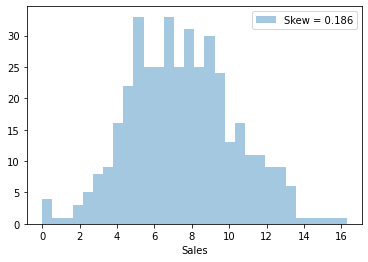

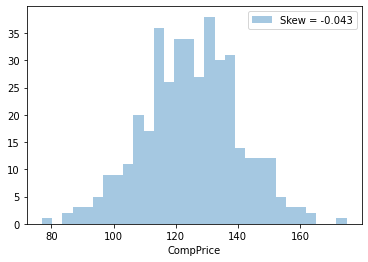

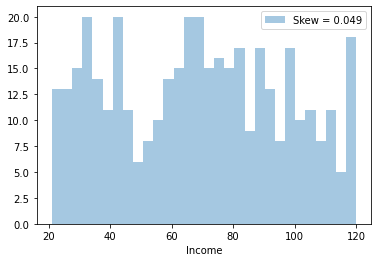

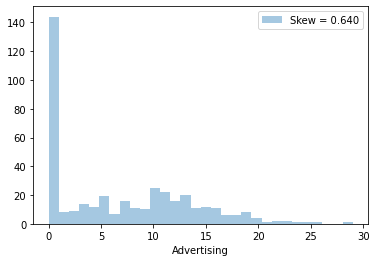

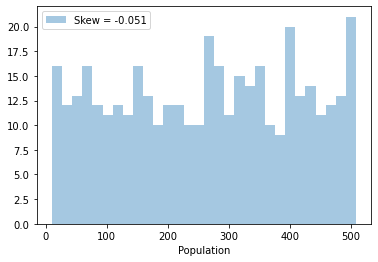

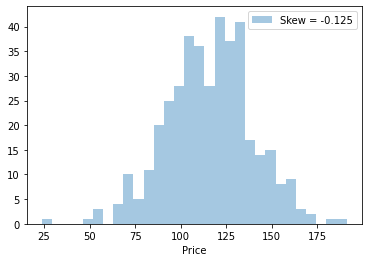

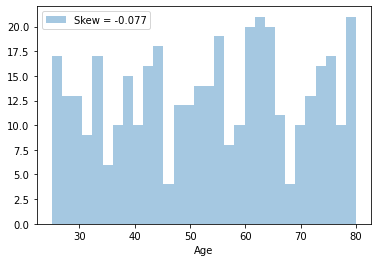

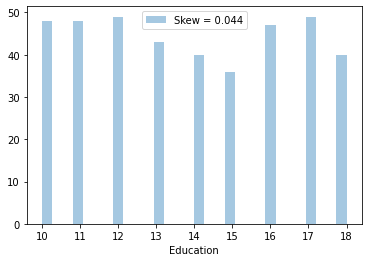

In [15]:
numerical_features = [feature for feature in company_data.columns if company_data[feature].dtypes != 'O']
for feat in numerical_features:
    skew = company_data[feat].skew()
    sns.distplot(company_data[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

#### Observation
* None of the features is normally distributed.

### Outliers

In [16]:
numerical_features

['Sales',
 'CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'Age',
 'Education']

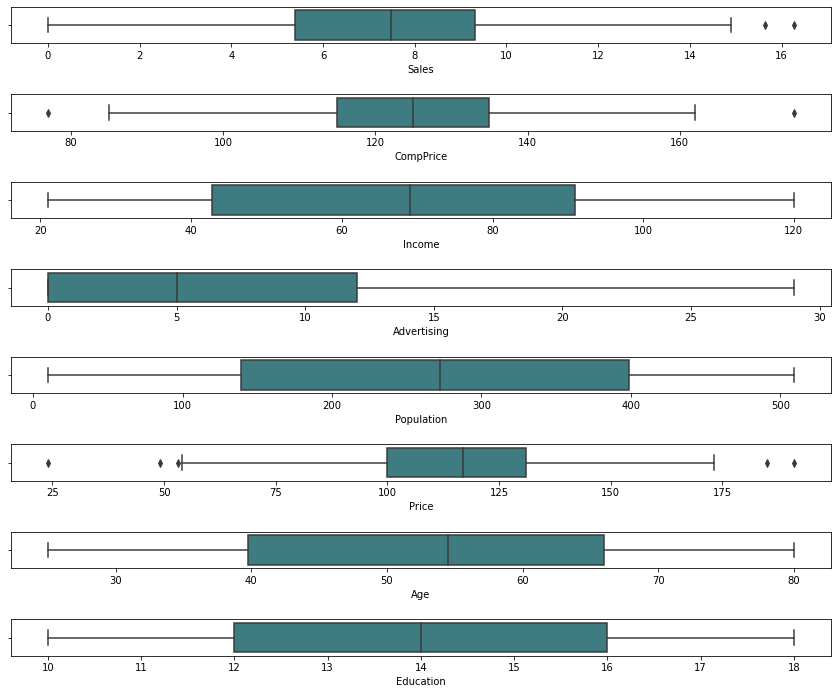

In [17]:
outliers = company_data.copy() 
fig, axes = plt.subplots(8,1,figsize=(12,10),sharex=False,sharey=False)
sns.boxplot(x='Sales', data= outliers,palette='crest',ax=axes[0])
sns.boxplot(x='CompPrice',data= outliers,palette='crest',ax=axes[1])
sns.boxplot(x='Income',data= outliers,palette='crest',ax=axes[2])
sns.boxplot(x='Advertising',data= outliers,palette='crest',ax=axes[3])
sns.boxplot(x='Population',data= outliers,palette='crest',ax=axes[4])
sns.boxplot(x='Price',data= outliers,palette='crest',ax=axes[5])
sns.boxplot(x='Age',data= outliers,palette='crest',ax=axes[6])
sns.boxplot(x='Education',data= outliers,palette='crest',ax=axes[7])
plt.tight_layout(pad=2.0)

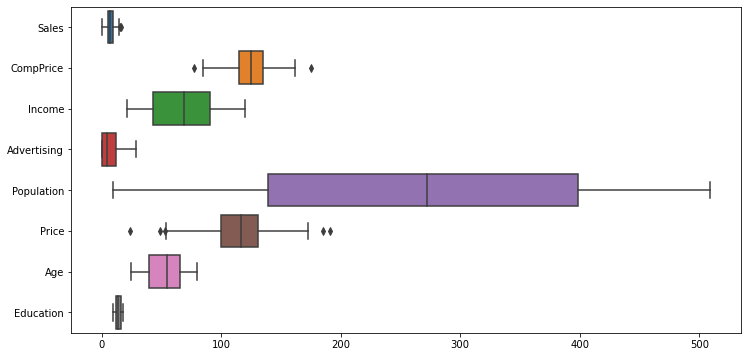

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(data=company_data[numerical_features], orient="h")
plt.show()

#### Observation:
* Population has a mean that is much superior to the other constituents as we already saw in the previous section.

### Multivariate Analysis
* Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

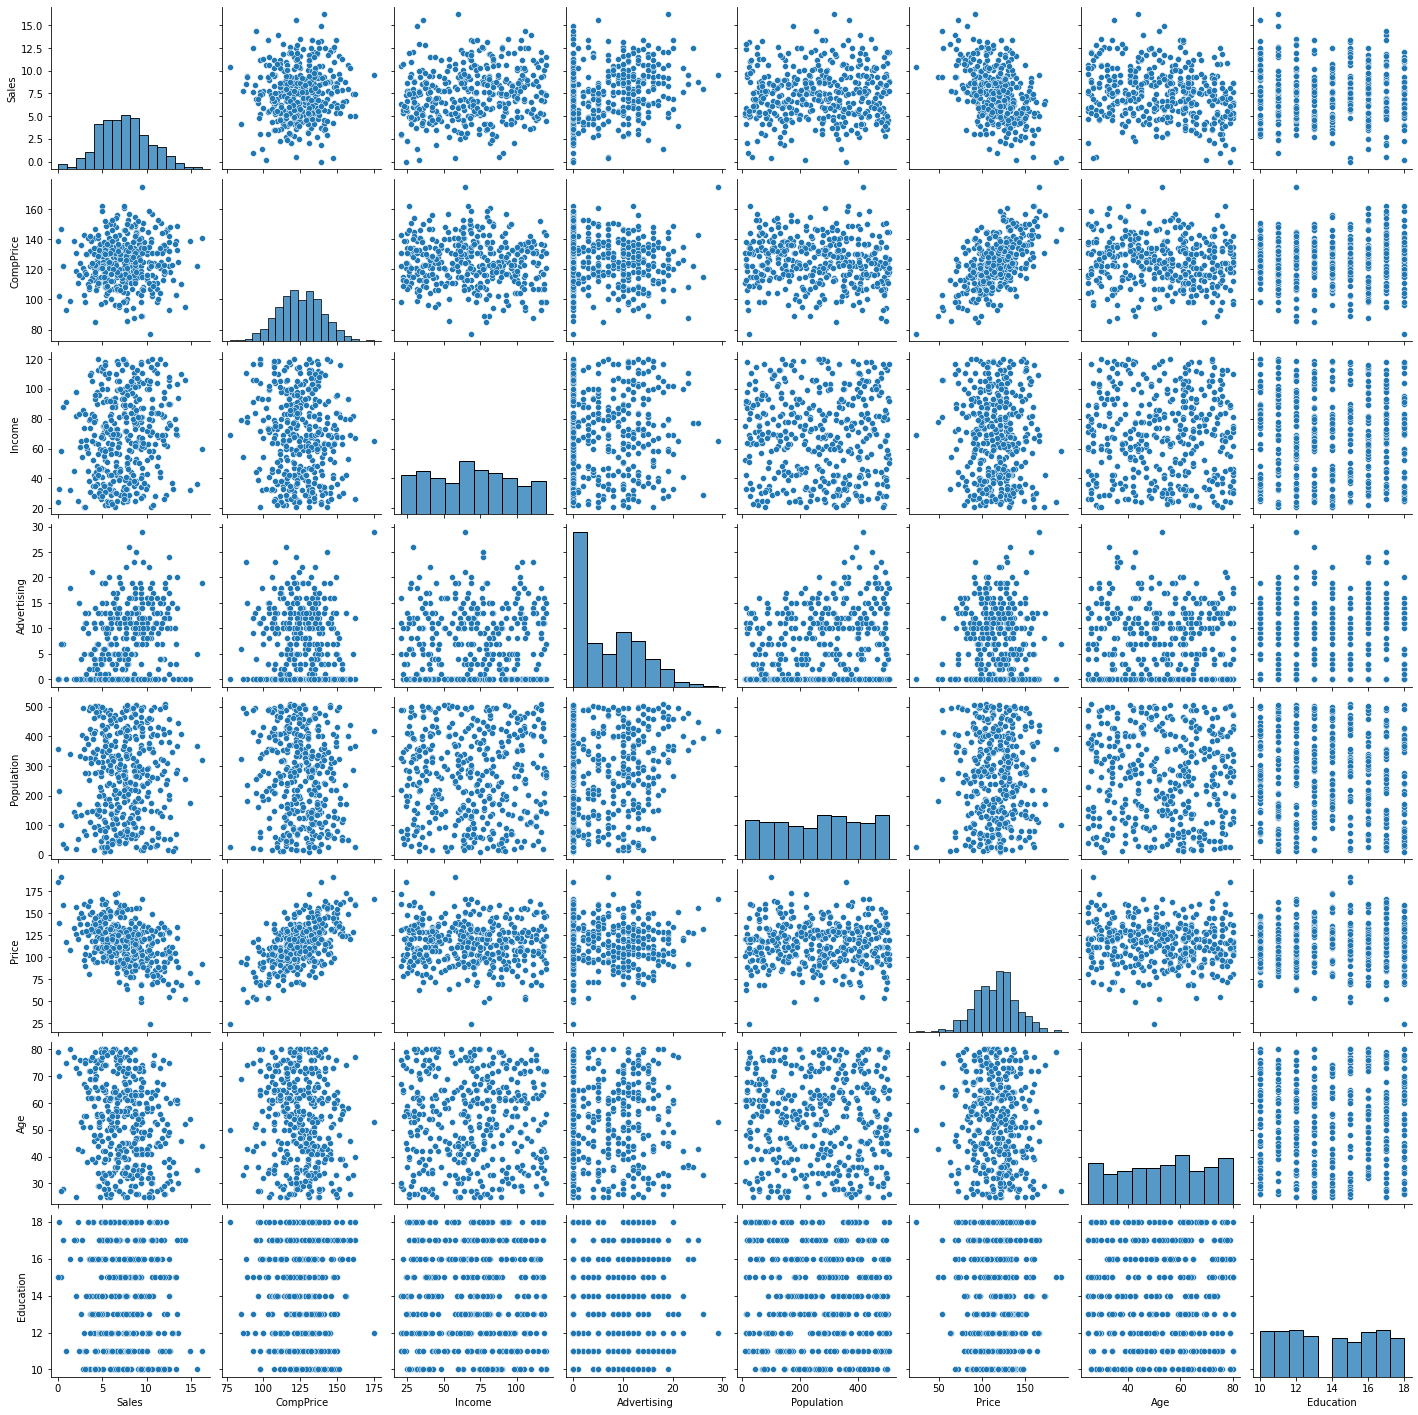

In [19]:
sns.pairplot(company_data, palette='coolwarm')
plt.show()

#### Having a look at the correlation matrix

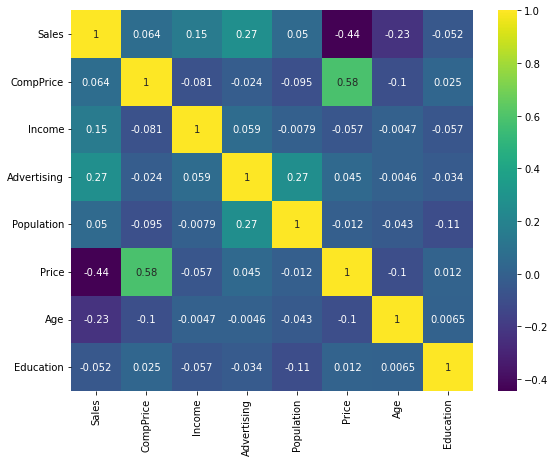

In [20]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(company_data.corr(), annot=True, fmt='.2g', cmap="viridis")
plt.show()

Index(['ShelveLoc', 'Urban', 'US', 'SalesCat'], dtype='object')


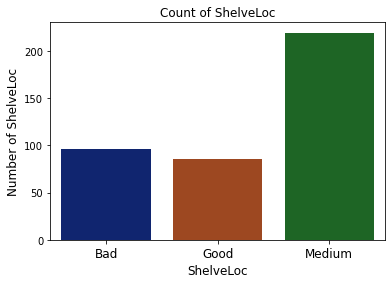

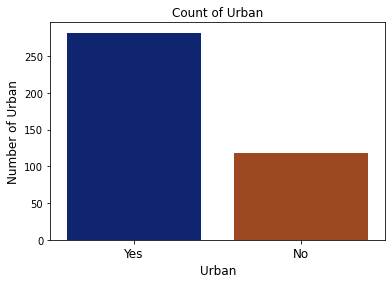

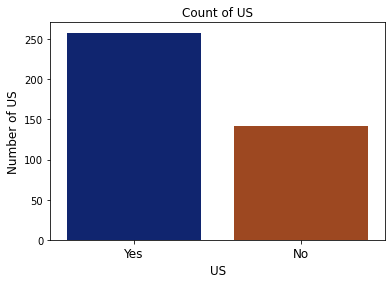

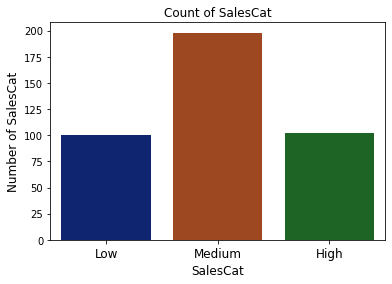

In [21]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(6,4))
    unique = company_data1[column].value_counts(ascending=True);   
    plt.title("Count of "+ column)
    sns.countplot(data= company_data1, x=column, palette = "dark")
    plt.xticks(rotation = 0, size = 12)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)
plt.show()

#### Let's plot pair plot to visualise the attributes all at once

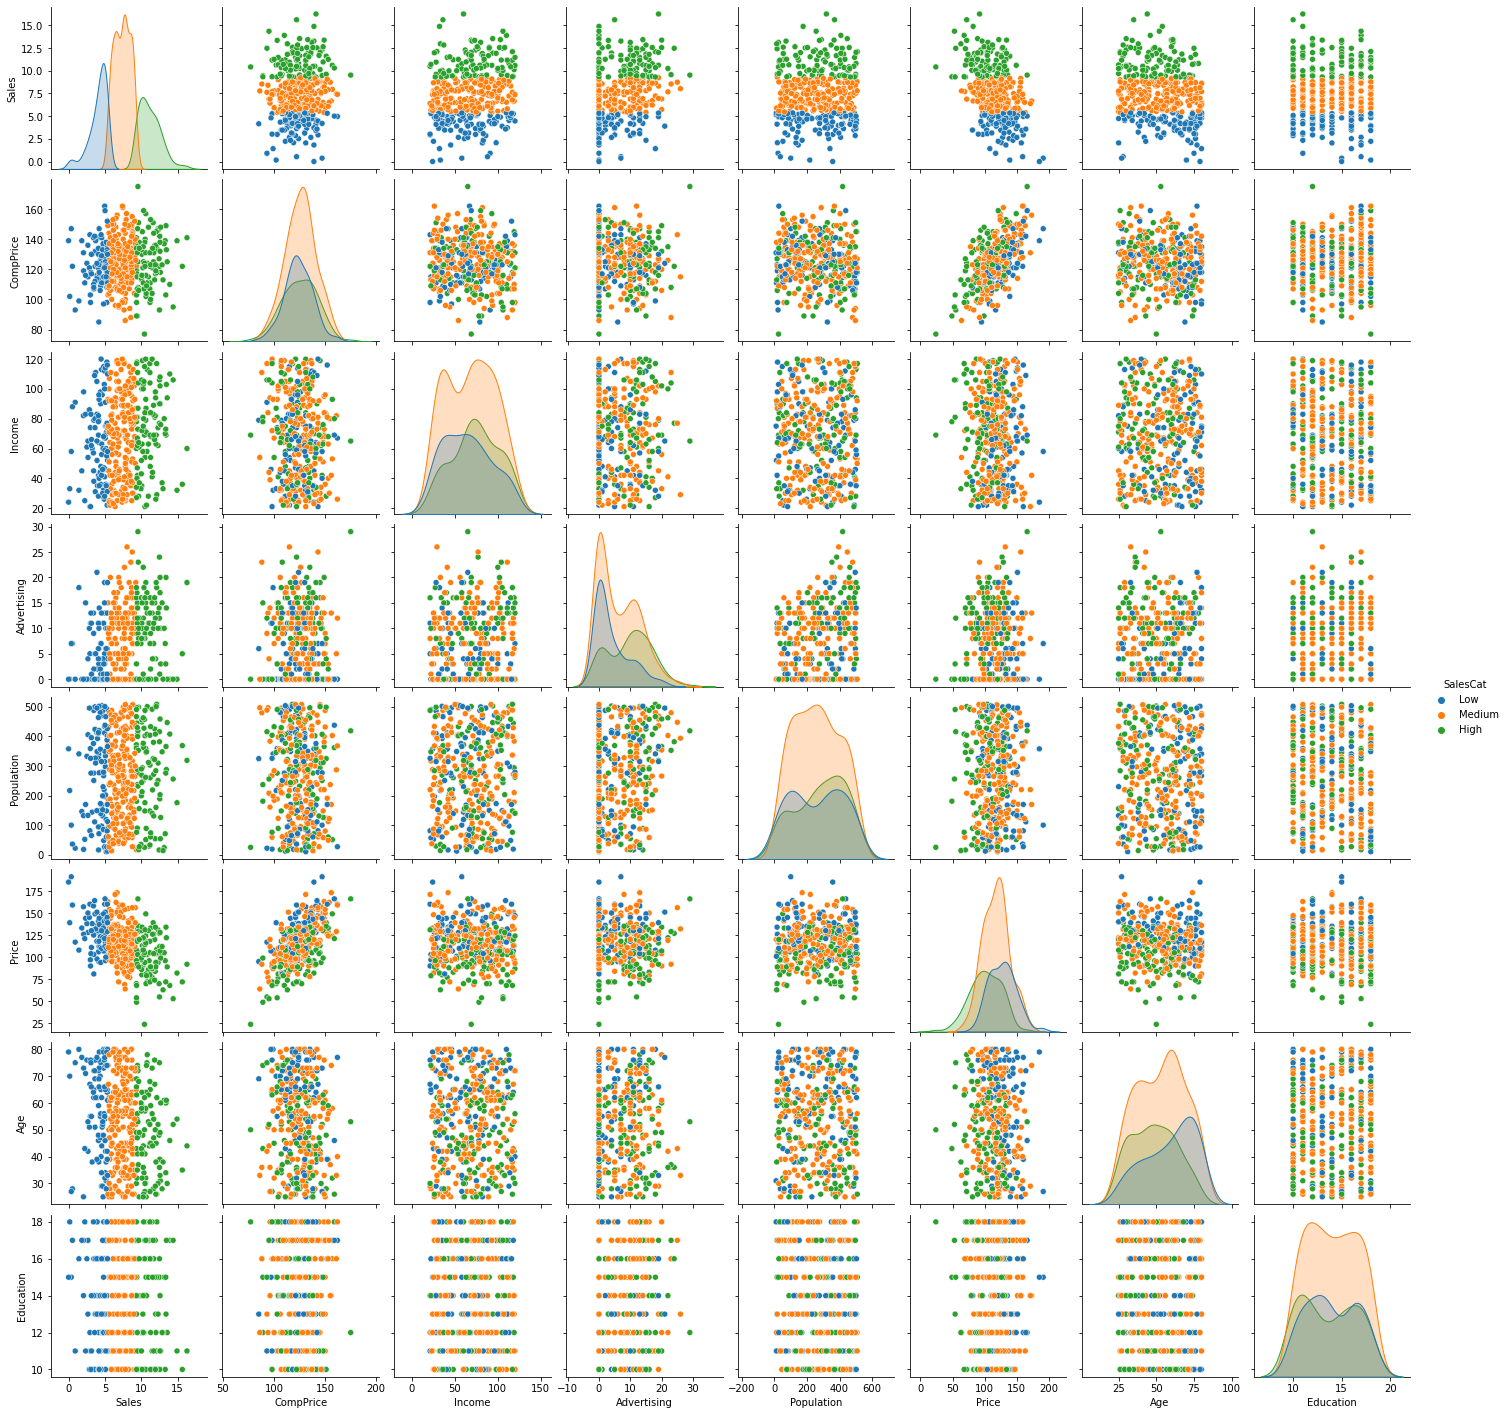

In [22]:
sns.pairplot(data= company_data1, hue = 'SalesCat')
plt.show()

In [23]:
company_data_dummi = company_data1.copy()
company_data_dummi.drop('Sales',axis=1, inplace =True)
company_data_dummi = pd.get_dummies(company_data_dummi.iloc[:,:-1])
company_data_dummi.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


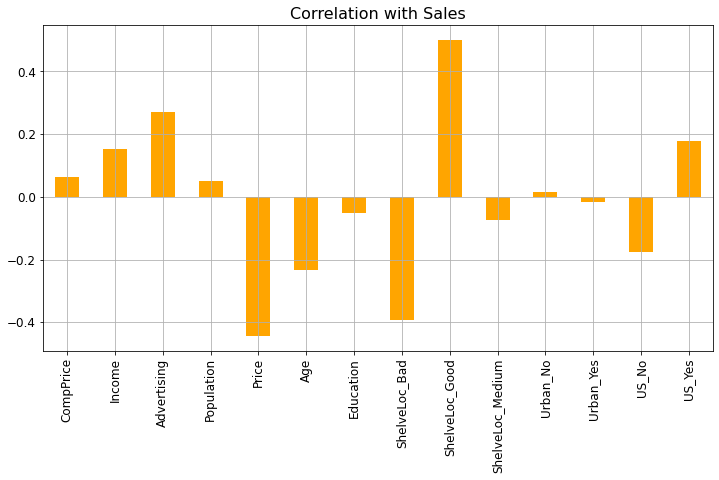

In [24]:
company_data2 = company_data_dummi.copy()

correlations = company_data2.corrwith(company_data1.Sales)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations = correlations[correlations <0].sort_values(ascending = False)

correlations.plot.bar(figsize = (12,6), fontsize = 12, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Sales',fontsize = "16")
plt.show()

### Checking for Imbalanced or balanced dataset with regards to the Target

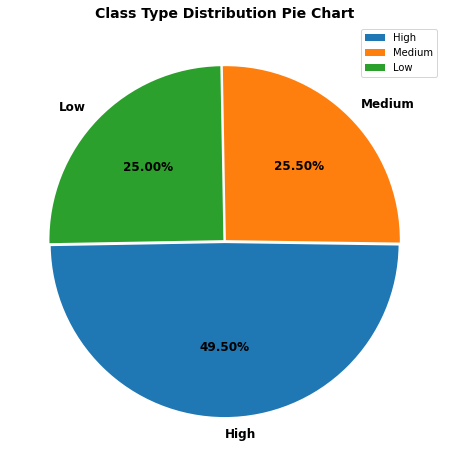

In [25]:
plt.figure(figsize = (9,8))
plt.pie(company_data1['SalesCat'].value_counts(), labels= company_data1.SalesCat.unique(), explode = [0.01,0.01,0.01],
       autopct= '%.2f%%', startangle= 181, textprops = {'size':'large','fontweight':'bold','rotation':'0','color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 14, fontweight = 'bold')
plt.show()

**Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.**

Here, the class “High” is called the majority class, and the much smaller in size “Low” and “Medium” class is called the minority class.

In [26]:
company_data1.SalesCat.value_counts()

Medium    198
High      102
Low       100
Name: SalesCat, dtype: int64

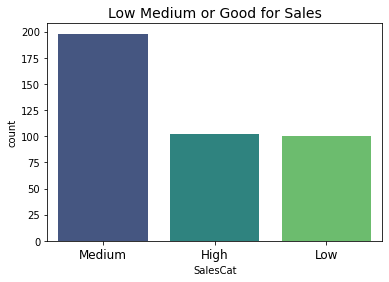

In [27]:
sns.countplot(x= 'SalesCat', data= company_data1, palette= 'viridis', order= company_data1['SalesCat'].value_counts().index)
plt.xticks(fontsize= 12)
plt.title('Low Medium or Good for Sales', fontsize= 14)
plt.show()

## 5. Data Pre-Processing

In [28]:
company_data3 = company_data1.copy()
company_data3.drop('Sales',axis=1, inplace =True)
company_data3 = pd.get_dummies(company_data3.iloc[:,:-1])
company_data3.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


In [29]:
company_data3['Sales'] = company_data1.SalesCat
company_data3.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes,Sales
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1,High
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1,High
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1,High
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1,Medium
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0,Low


### 5.1 Lable Encoding

In [30]:
le = LabelEncoder()
le.fit(company_data3["Sales"])
company_data3["Sales"]=le.transform(company_data3["Sales"])
company_data3.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes,Sales
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1,0
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1,0
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1,0
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1,2
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0,1


#### Split into input (x) and output (y) variables

In [31]:
x = company_data3.iloc[:, :-1]
y=  company_data3.Sales

#### Feature extraction

In [32]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(x, y)

#### Summarize scores

In [33]:
scores = fit.scores_
features = fit.transform(x)

In [34]:
score_company_data = pd.DataFrame(list(zip(x.columns, scores)), columns =['Feature','Score'])
score_company_data.sort_values(by="Score", ascending=False, inplace=True)
score_company_data

,Feature,Score
4,Price,300.881058
2,Advertising,251.767458
3,Population,141.113336
5,Age,106.577639
8,ShelveLoc_Good,66.174919
1,Income,65.145403
7,ShelveLoc_Bad,48.524460
12,US_No,13.109136
9,ShelveLoc_Medium,8.654770
13,US_Yes,7.215106


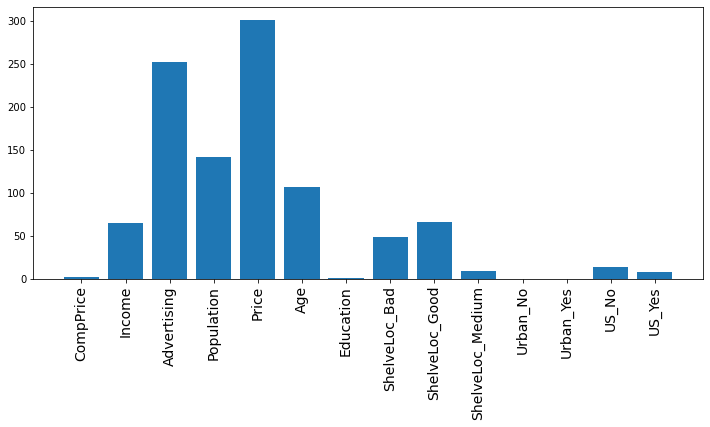

In [35]:
fig, axes = plt.subplots(figsize=(12,5))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation= 90, size= 14)
plt.show()

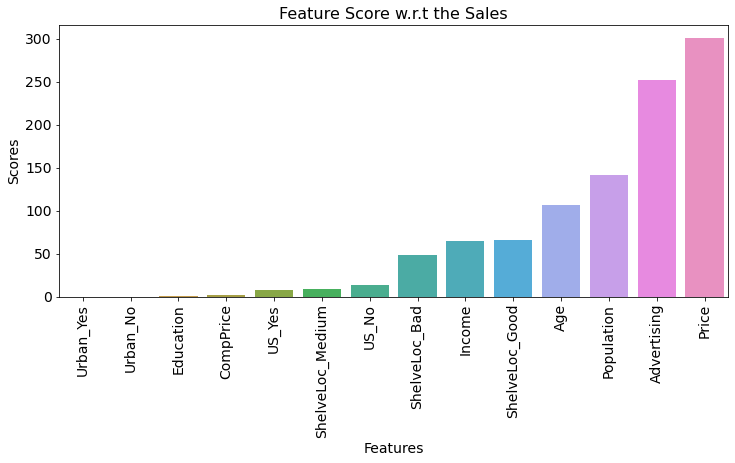

In [36]:
plt.figure(figsize=(12,5))
sns.barplot(x='Feature', y="Score", data= score_company_data, order=score_company_data.sort_values('Score').Feature)
plt.xlabel("Features", size=14)
plt.ylabel("Scores", size=14)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Score w.r.t the Sales", size=16)
plt.show()

In [37]:
model_data = company_data3[['Price', 'Advertising','Population', 'Income', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Bad', 'ShelveLoc_Medium','Sales']]
model_data.head()

,Price,Advertising,Population,Income,Age,ShelveLoc_Good,ShelveLoc_Bad,ShelveLoc_Medium,Sales
0,120,11,276,73,42,0,1,0,0
1,83,16,260,48,65,1,0,0,0
2,80,10,269,35,59,0,0,1,0
3,97,4,466,100,55,0,0,1,2
4,128,3,340,64,38,0,1,0,1


### 5.2 Random Forest Built-in Feature Importance

In [38]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
rf_classifier.fit(x, y)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20], 'min_samples_leaf': [5,10,20,50,100,200], 'n_estimators': [10,25,30,50,100,200]}

grid_search = GridSearchCV(estimator= rf, param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x, y)
rf_best = grid_search.best_estimator_

print('Checking the oob score :', rf_classifier.oob_score_)
print('Best Score             :', grid_search.best_score_)
print('RF Best Model          :', rf_best)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
Checking the oob score : 0.635
Best Score             : 0.66
RF Best Model          : RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


### Now let’s sort the data with the help of feature importance

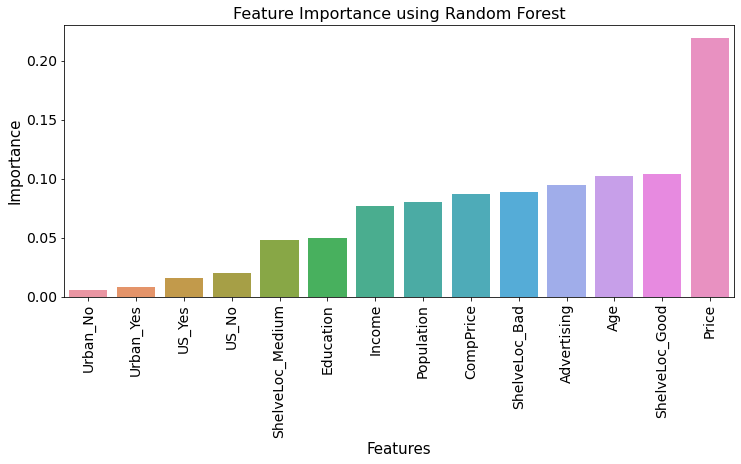

In [39]:
rf_best.feature_importances_
imp_df = pd.DataFrame({"Feature": x.columns, "Importance": rf_best.feature_importances_})

plt.figure(figsize=(12,5))
sns.barplot(x= 'Feature', y= "Importance", data= imp_df, order= imp_df.sort_values('Importance').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Feature Importance using Random Forest", size=16)
plt.show()

### 5.3 Test Train Split With Imbalanced Dataset

In [40]:
x = model_data.drop('Sales',axis=1)
y = model_data['Sales']

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [42]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (280, 8)
Shape of x_test  :  (120, 8)
Shape of y_train :  (280,)
Shape of y_test  :  (120,)


### StratifiedKFold

In [43]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_x, test_x = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data :',counter_train)
print('Testing Data  :',counter_test)

Training Data : Counter({2: 178, 0: 92, 1: 90})
Testing Data  : Counter({2: 20, 1: 10, 0: 10})


## 6. About Stratify 
* Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

### 6.1. Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [44]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n==========================================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n==========================================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("__________________________________________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("__________________________________________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [45]:
rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(train_x, train_y)

print_score(rf_clf1, train_x, train_y, test_x, test_y, train=True)
print_score(rf_clf1, train_x, train_y, test_x, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
__________________________________________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    92.0  90.0  178.0       1.0      360.0         360.0
__________________________________________________________________________
Confusion Matrix: 
 [[ 92   0   0]
 [  0  90   0]
 [  0   0 178]]

Test Result:
Accuracy Score: 52.50%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy  macro avg  weighted avg
precision   0.800000   0.375000   0.518519     0.525   0.564506      0.553009
recall      0.400000   0.300000   0.700000     0.525   0.466667      0.525000
f1-score    0.533333   0.333333   

### 6.2 Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [46]:
rf_clf2 = RandomForestClassifier(n_estimators=100)
rf_clf2.fit(x_train, y_train)

print_score(rf_clf2, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf2, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
__________________________________________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    71.0  70.0  139.0       1.0      280.0         280.0
__________________________________________________________________________
Confusion Matrix: 
 [[ 71   0   0]
 [  0  70   0]
 [  0   0 139]]

Test Result:
Accuracy Score: 64.17%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.730769   0.636364   0.611111  0.641667    0.659415      0.648336
recall      0.612903   0.466667   0.745763  0.641667    0.608444      0.641667
f1-score    0.666667   0.538462

#### Observation:
* In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

## 7. Handling imbalance data using SMOTE based techniques

**Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. In this article, I am specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.**

In [47]:
x = model_data.drop(['Sales'], axis=1)
y = model_data['Sales']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=15,stratify=y)

In [48]:
print("Shape of x_train : ",x_train.shape)
print("Shape of x_test  : ",x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of x_train :  (280, 8)
Shape of x_test  :  (120, 8)
Shape of y_train :  (280,)
Shape of y_test  :  (120,)


### 7.1 SMOTE Oversampling technique

In [49]:
counter1 = Counter(y_train)
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)
counter2 = Counter(y_train_sm)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 139, 2: 139, 0: 139})


### 7.2 ADASYN: Adaptive Synthetic Sampling Approach

In [50]:
counter1 = Counter(y_train)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
counter2 = Counter(y_train_ada)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 140, 2: 139, 0: 135})


### 7.3 Hybridization: SMOTE + Tomek Links

In [51]:
counter1 = Counter(y_train)
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)
counter2 = Counter(y_train_smtom)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 129, 0: 129, 2: 121})


### 7.4 Hybridization: SMOTE + ENN

In [52]:
counter1 = Counter(y_train)
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)
counter2 = Counter(y_train_smenn)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({0: 68, 1: 57, 2: 12})


### 7.5 Performance Analysis after Resampling

In [53]:
sample_data = {'ACTUAL':[x_train, y_train], 'SMOTE':[x_train_sm, y_train_sm], 'ADASYN':[x_train_ada, y_train_ada],
               'SMOTE_TOMEK':[x_train_smtom, y_train_smtom], 'SMOTE_ENN':[x_train_smenn, y_train_smenn]}

In [54]:
def test_eval(clf_model, x_test, y_test, algo= None, sampling=None):
    # Test set prediction
    y_prob = clf_model.predict_proba(x_test)
    y_pred = clf_model.predict(x_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    
    f1        = f1_score(y_test, y_pred, average='micro')
    recall    = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    return algo,precision,recall,f1,sampling

In [55]:
model_params = {'random-forest' : {'model' : RandomForestClassifier(), 'params' : {"n_estimators": [5, 10, 15, 20, 25], 
                'max_depth': [i for i in range(5,16,2)], 'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
                'min_samples_leaf': [1, 2, 5], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', 'sqrt', 'auto']}}}

In [56]:
cv = StratifiedKFold (n_splits=5, random_state=100, shuffle=True)
output = []
for model, model_hp in model_params.items():
    for resampl, data in sample_data.items():
        clf3 = RandomizedSearchCV (model_hp['model'], model_hp['params'], cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf3.fit(data[0], data[1])
        clf_best1 = clf3.best_estimator_
        print('='*60)
        print(model+' with ' + resampl)
        print('-'*60)
        output.append(test_eval(clf_best1, x_test, y_test, model, resampl))

random-forest with ACTUAL
------------------------------------------------------------
Confusion Matrix
[[17  0 14]
 [ 0  8 22]
 [10  4 45]] 

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.55      0.59        31
           1       0.67      0.27      0.38        30
           2       0.56      0.76      0.64        59

    accuracy                           0.58       120
   macro avg       0.62      0.53      0.54       120
weighted avg       0.60      0.58      0.56       120
 

random-forest with SMOTE
------------------------------------------------------------
Confusion Matrix
[[24  4  3]
 [ 2 23  5]
 [24 17 18]] 

Classification Report
              precision    recall  f1-score   support

           0       0.48      0.77      0.59        31
           1       0.52      0.77      0.62        30
           2       0.69      0.31      0.42        59

    accuracy                           0.54       120
   macro avg    

### As the results can be compared, ADASYN technique gave the best results we are going to use it further

In [57]:
counter1 = Counter(y_train)
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)
counter2 = Counter(y_train_ada)

print('Before :',counter1)
print('After  :',counter2)

Before : Counter({2: 139, 0: 71, 1: 70})
After  : Counter({1: 140, 2: 139, 0: 135})


In [58]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter1 = Counter(y_train_ada)
counter2 = Counter(y_train)
print('Before           :',counter1)
print('After            :',counter2)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Before           : Counter({1: 140, 2: 139, 0: 135})
After            : Counter({1: 98, 2: 97, 0: 94})
Shape of X_train :  (289, 8)
Shape of X_test  :  (125, 8)
Shape of y_train :  (289,)
Shape of y_test  :  (125,)


## 8. Random Forest
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

### 8.1 Random Forest hyperparameter tuning

#### Base model

In [59]:
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 12) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [60]:
loc = np.array(score_array).max()
score_array.index(loc)+1

26

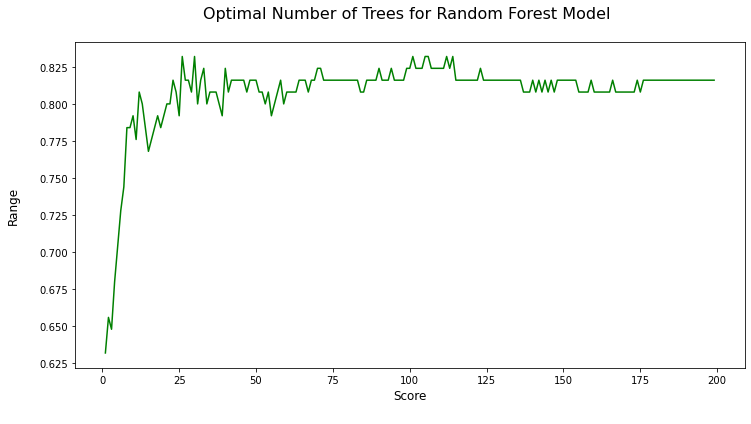

In [61]:
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,200),score_array, color = 'g')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n', horizontalalignment="center", fontsize = 16)
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Randomized Search Cross Validation

In [62]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV (estimator=rf_clf, scoring='f1',param_distributions=random_grid,
                            n_iter=100, cv=3,verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 195, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True})
Train Result:
Accuracy Score: 94.12%
__________________________________________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.947368   0.923810   0.955056  0.941176    0.942078      0.941960
recall      0.957447   0.989796   0.876289  0.941176    0.941177      0.941176
f1-score    0.952381   0.955665   0.913978  0.941176    0.940675      0.940605
support    94.000000  98.000000  97.000000  0.941176  289.000000    289.000000
__________________________________________________________________________
Confusion Matrix: 
 [[90  1  3]
 [ 0 97  1]
 [ 5  7 85]]

Test Result:
Accuracy Score: 81.60%
__________________________________________________________________________
CLASSIFICATION RE

#### Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

### 8.2 Visualizing one of the decision tree in random forest

In [63]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=195,
                       random_state=42)

In [64]:
company_data1.SalesCat.unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']

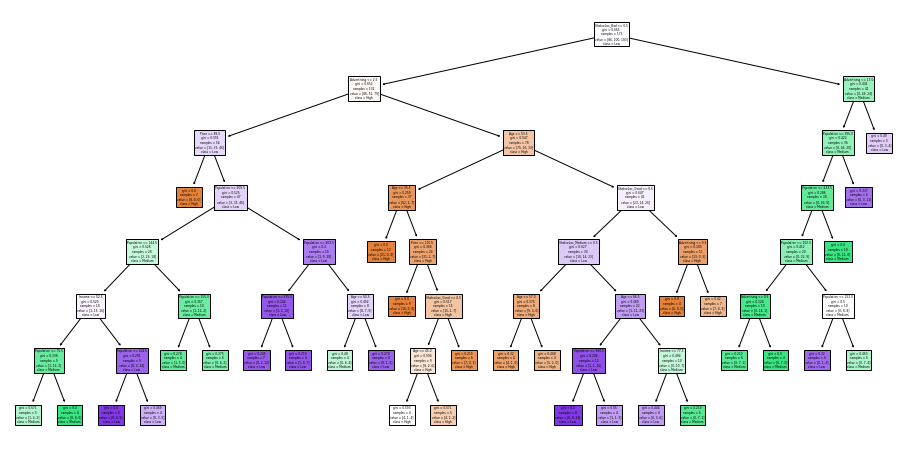

In [65]:
plt.figure(figsize=(16,8))
plot_tree(rf_best.estimators_[190], feature_names = model_data.columns,class_names=company_data1.SalesCat.unique(),filled=True)
plt.show()

## 9. Model Deployement

In [66]:
from pickle import dump

In [67]:
dump(rf_clf,open('company_data_intell.pkl','wb'))

# THE END !!!